# Lab assignment №1, part 3

This lab assignment consists of several parts. You are supposed to make some transformations, train some models, estimate the quality of the models and explain your results.

Several comments:
* Don't hesitate to ask questions, it's a good practice.
* No private/public sharing, please. The copied assignments will be graded with 0 points.
* Blocks of this lab will be graded separately.

__*This is the third part of the assignment. First and second parts are waiting for you in the same directory.*__

##  Part 3. SVM and kernels

Kernels concept get adopted in variety of ML algorithms (e.g. Kernel PCA, Gaussian Processes, kNN, ...).

So in this task you are to examine kernels for SVM algorithm applied to rather simple artificial datasets.

To make it clear: we will work with the classification problem through the whole notebook. 

In [386]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Let's generate our dataset and take a look on it.

In [318]:
def draw_colorful_points(points, labels):
    plt.scatter(points[:, 0], points[:, 1], c=labels)

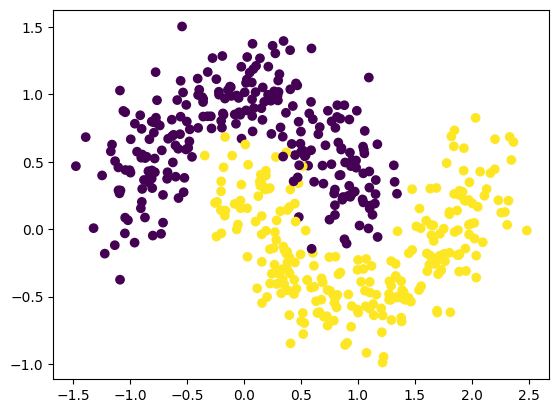

In [319]:
moons_points, moons_labels = make_moons(n_samples=500, noise=0.2, random_state=42)
draw_colorful_points(moons_points, moons_labels)

In [321]:
moons_train, moons_val, moons_test, moons_label_train, moons_label_val, moons_label_test = \
    train_val_test_split(moons_points, moons_labels) 

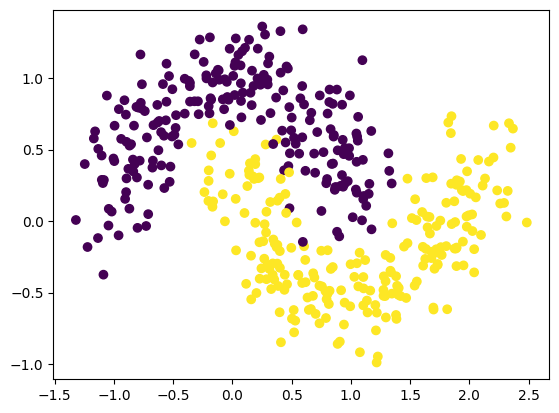

In [322]:
draw_colorful_points(moons_train, moons_label_train)

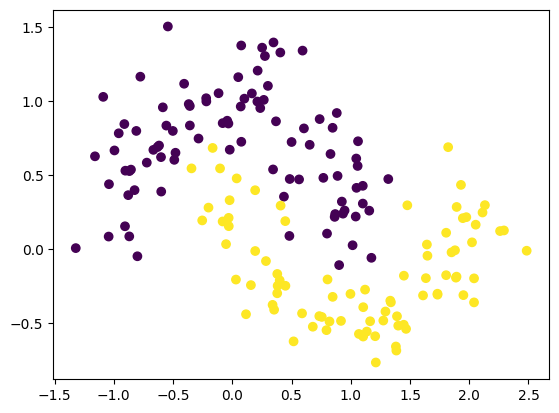

In [323]:
draw_colorful_points(moons_test, moons_label_test)

There is enough points, so shape is preserved in train data set.

## 1.1 Pure models.
First let's try to solve this case with good old Logistic Regression and simple (linear kernel) SVM classifier.

Train LR and SVM classifiers (choose params by hand, no CV or intensive grid search neeeded) and plot their decision regions. Calculate one preffered classification metric.

Describe results in one-two sentences.

_Tip:_ to plot classifiers decisions you colud use either sklearn examples ([this](https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mlp_alpha.html#sphx-glr-auto-examples-neural-networks-plot-mlp-alpha-py) or any other) and mess with matplotlib yourself or great [mlxtend](https://github.com/rasbt/mlxtend) package (see their examples for details)

_Pro Tip:_ wirte function `plot_decisions` taking a dataset and an estimator and plotting the results cause you want to use it several times below

In [324]:
from mlxtend.plotting import plot_decision_regions
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import accuracy_score

lr = LogisticRegression(solver='saga', tol=1e-3, max_iter=1000, C=1, class_weight='balanced')
svm = SVC(kernel="linear", class_weight='balanced')


In [325]:
def show_decisions(clf, X, y, a=0.35, ax=None):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=a)
    clf.fit(X_train, y_train)
    plot_decision_regions(X, y, clf=clf, ax=ax)
    y_pred = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)
    y_overall = np.concatenate((y_train, y_test)) # shuffled y
    y_pred_overall = np.concatenate((y_pred_train, y_pred))
    plt.title(f'''Test accuracy={accuracy_score(y_pred=y_pred, y_true=y_test)}
Train accuracy={accuracy_score(y_pred=y_pred_train, y_true=y_train)}
Overall accuracy={accuracy_score(y_pred=y_pred_overall, y_true=y_overall)}''')


def show_decisions_moons(clf, ax=None):
    show_decisions(clf, X=moons_points, y=moons_labels, ax=ax)

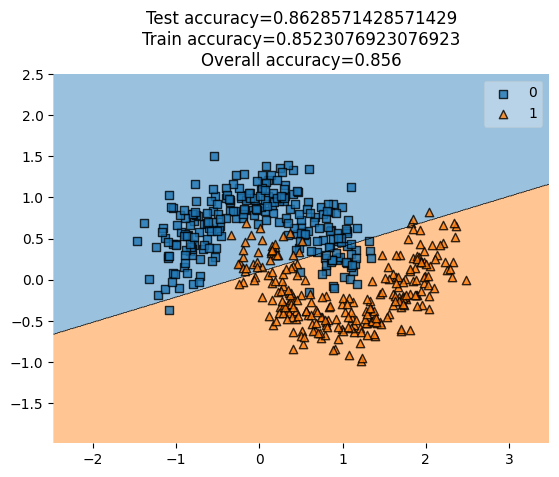

In [326]:
show_decisions_moons(lr)

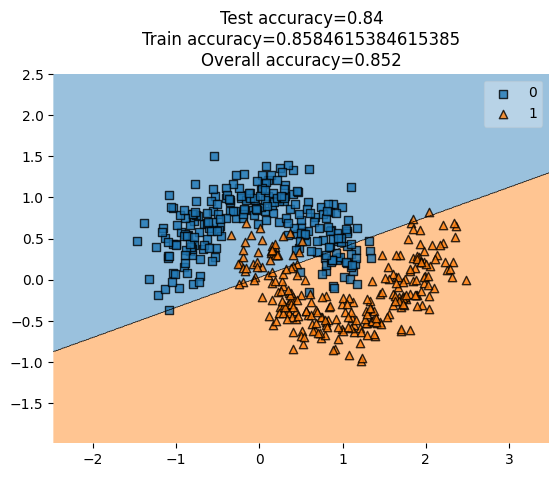

In [327]:
show_decisions_moons(svm)

Logistic Regression and linear SVM are almost the same. The line separates nicely the outer ends of moons, but, inevitably, makes many mistakes on inner ends. 

Linear SVM is a reasonable baseline

## 1.2 Kernel tirck

Now use different kernels (`poly`, `rbf`, `sigmoid`) on SVC to get better results. Play `degree` parameter and others.

For each kernel estimate optimal params, plot decision regions, calculate metric you've chosen eariler.

Write couple of sentences on:

* What have happenned with classification quality?
* How did decision border changed for each kernel?
* What `degree` have you chosen and why?

### poly

Let's try cubic polynomial right off the bat as the separating curve looks cubic to me

In [328]:
def mk_svm_poly(degree, C=1, class_weight='balanced'):
    return SVC(kernel="poly", class_weight=class_weight, degree=degree, C=C)
svm_cubic = mk_svm_poly(3)

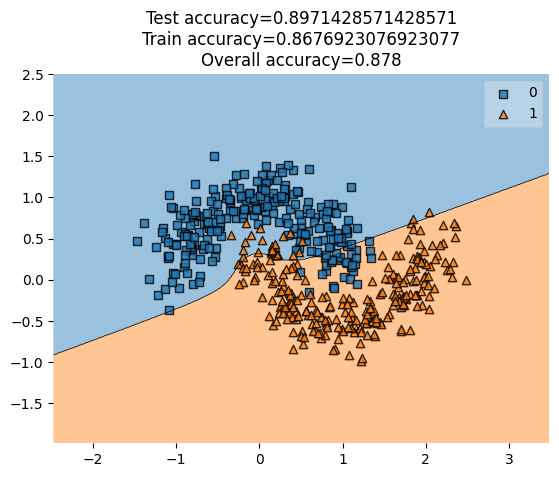

In [329]:
show_decisions_moons(svm_cubic)

Not bad! And accuracy improved, too. Let's see if weights can help. Since the classes are rather symmetric, we might hope that, fitting the first one nicely, we fit the second one nicely, too (given that the separating line is symmetric, too.) 

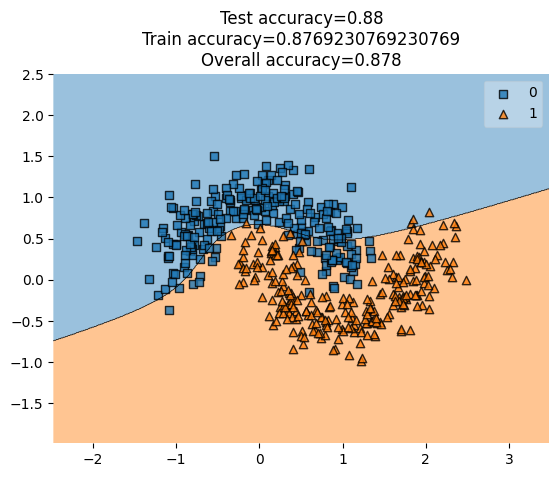

In [330]:
svm_cubic_w = mk_svm_poly(3, class_weight={0: 1, 1: 2})
show_decisions_moons(svm_cubic_w)

Weights fixed some false-1's but added false-0's. The symmetricity of the separation line did not live to up our hopes, and accuracy dropped

#### other degrees

In [331]:
def show_svm_poly_decisions(C=1, odds_only=True, start=1, end=11):
    #fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(25, 10), sharey=True)
    # for some reason, subplotting takes A LOT of time. I blame mlxtend

    step = 2 if odds_only else 1
    for j in range(start, end, step):
        show_decisions_moons(mk_svm_poly(j, C=C))
        plt.suptitle(f"degree={j}")
        plt.show()

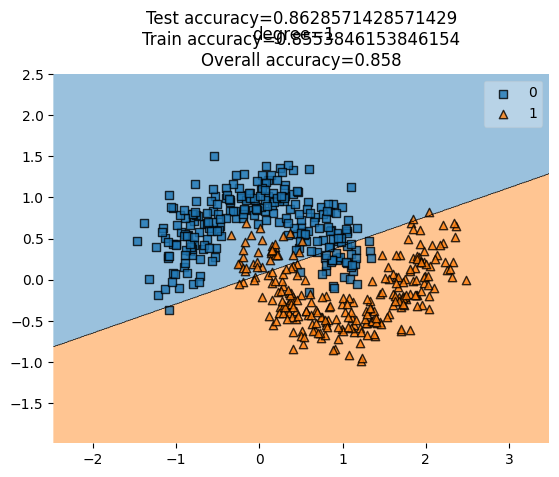

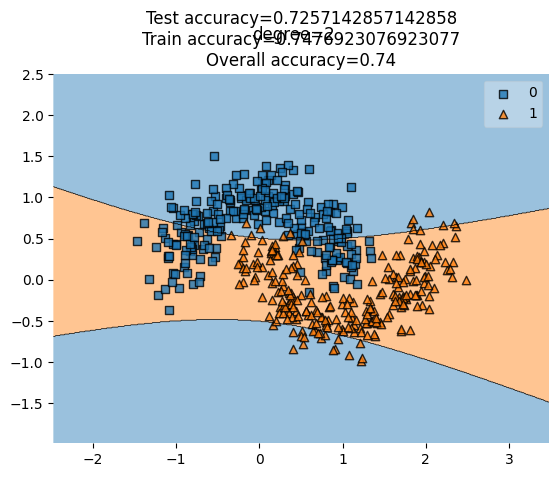

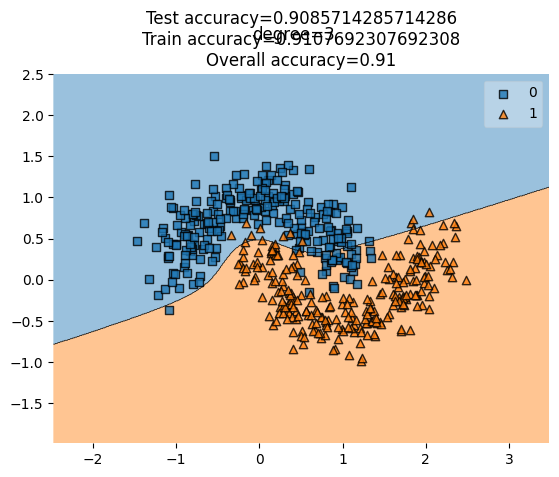

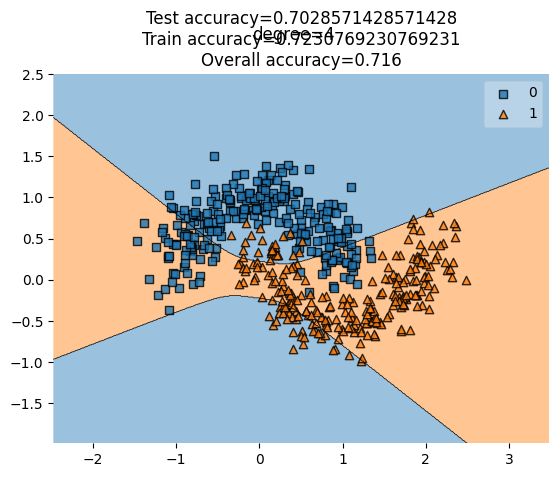

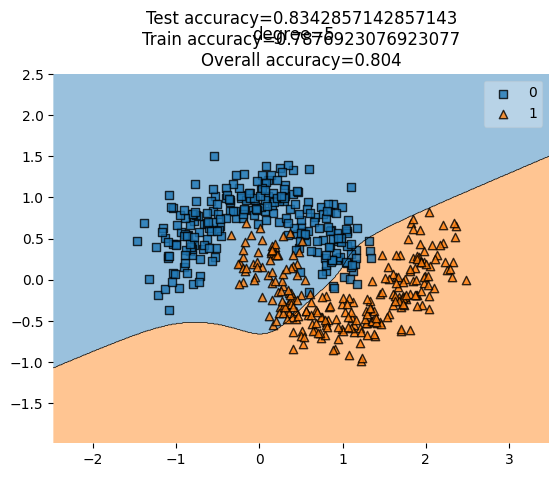

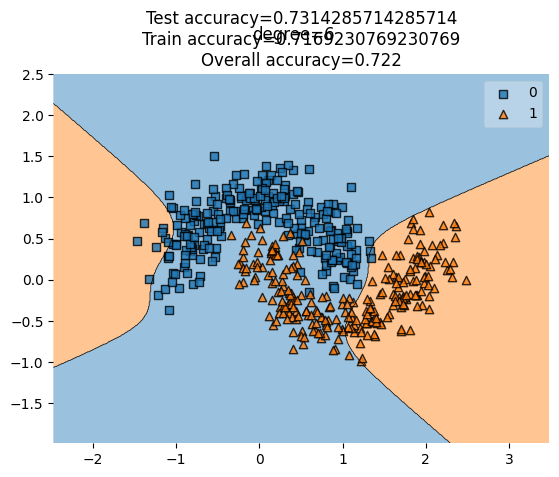

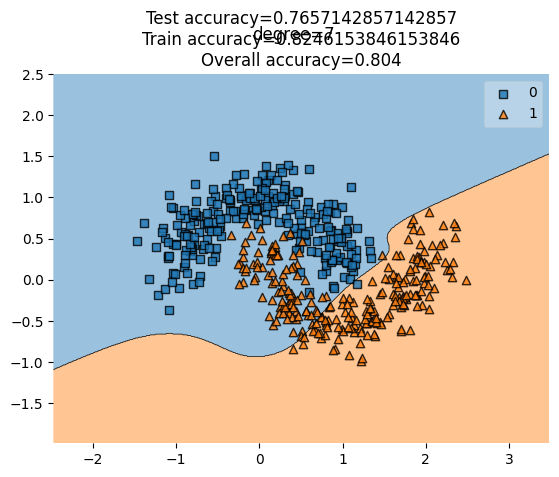

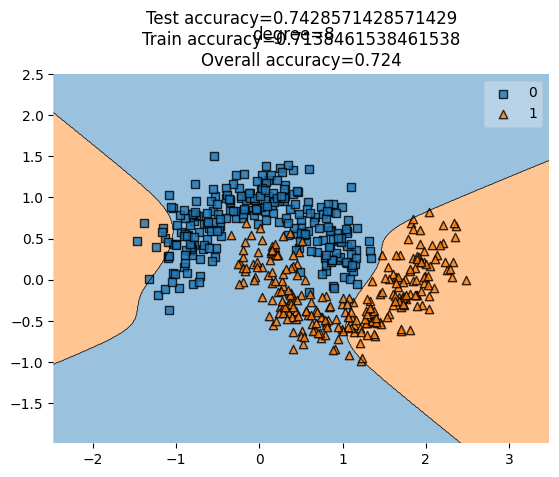

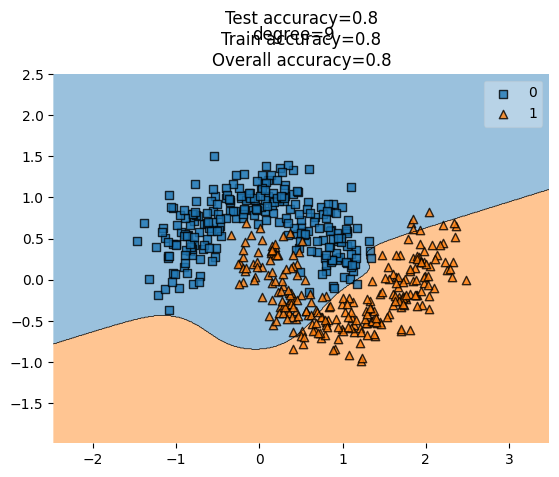

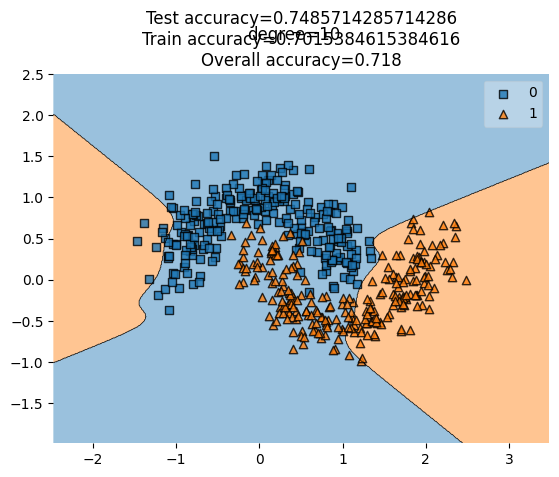

In [332]:
show_svm_poly_decisions(odds_only=False)

Very bad, actually. The best plots come from degrees 1 and 3 (as expected). The even degrees leave no hope

Maybe, it's the regularization to blame?

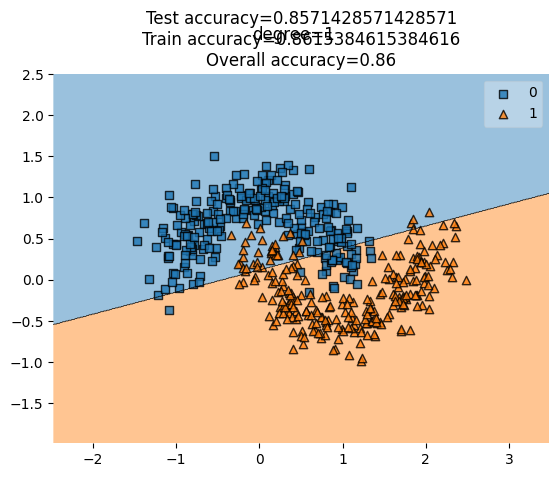

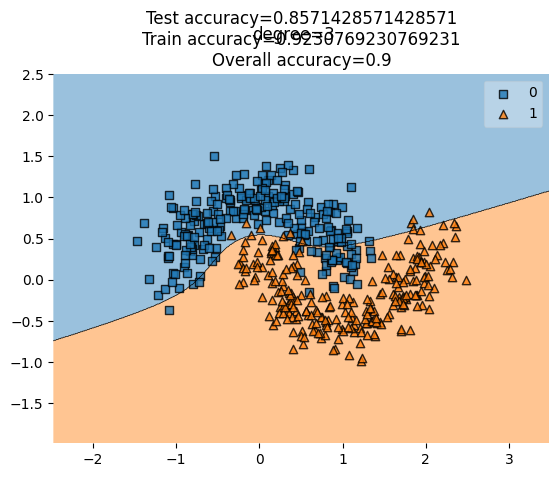

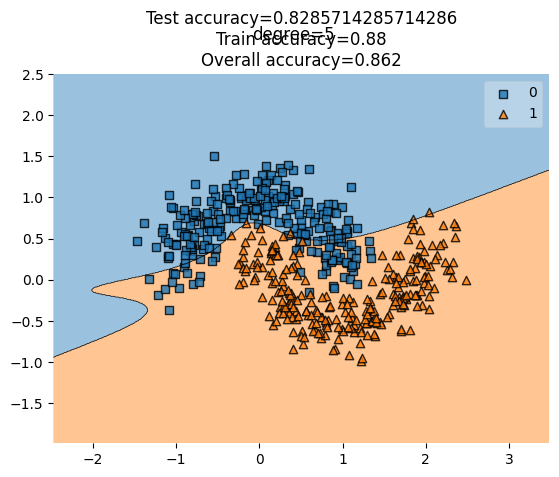

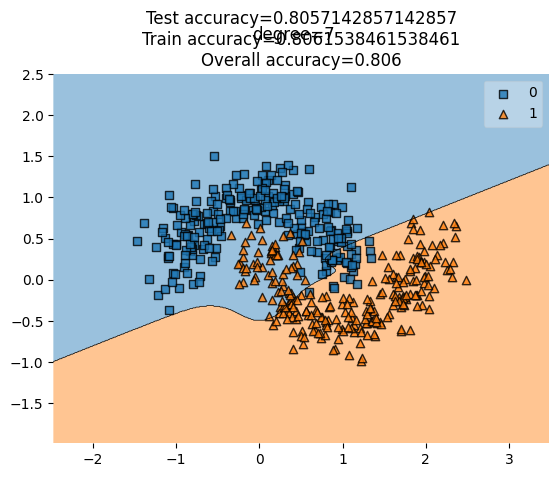

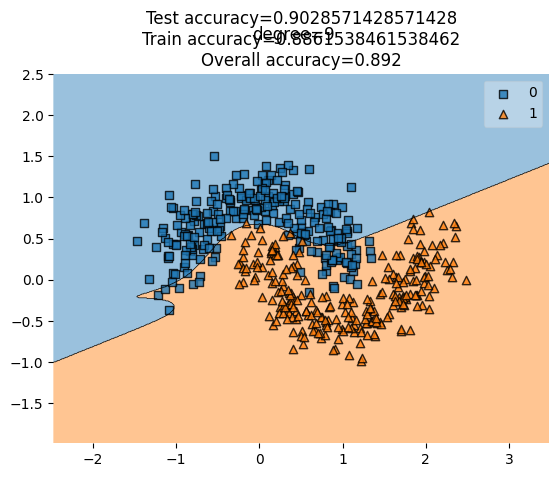

In [333]:
show_svm_poly_decisions(C=10)

Better, but not satisfactory. For $deg>3$ overfitting is visible

### radial basis function

In [334]:
def mk_svm_rbf(γ='scale'):
    return SVC(kernel="rbf", gamma=γ)

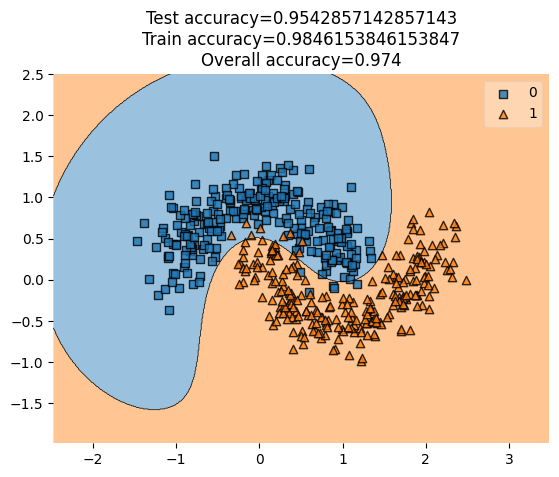

In [335]:
show_decisions_moons(mk_svm_rbf('scale'))

Beats the baseline by a lot; and is not too overfitted, despite the upper left corner being orange, for some reason (well, that's rbf's feature)

#### other $\gamma$'s

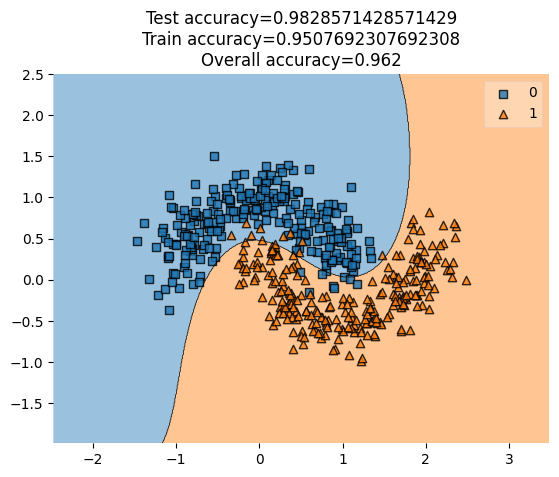

In [336]:
show_decisions_moons(mk_svm_rbf('auto'))

The orange left upper corner is gone, so I like this even more. I suppose, it's not REALLY gone, just moved further away, but if a blue point appeared that far from a cloud, it would mean an anomaly, which we don't really care about (we don't, right?).

According to documentation, $\gamma=scale$ means $\gamma = 1/(n_{feat} \cdot \sigma_X)$, and $\gamma = auto$ means just $\gamma = 1/n_{feat}$. Let's see what $\sigma_X$ is 

In [337]:
moons_train.var()

0.5663641264267337

Thus, $scale > auto$, in our case. And indeed, as examples below show, the greater $\gamma$ is, the tighter will be the area that encloses the 1s

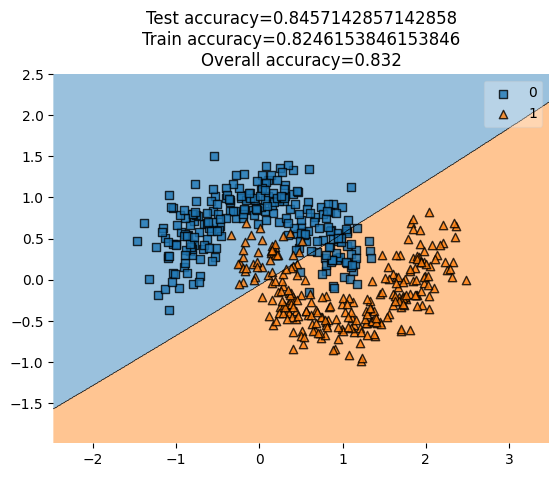

In [338]:
show_decisions_moons(mk_svm_rbf(0.01))

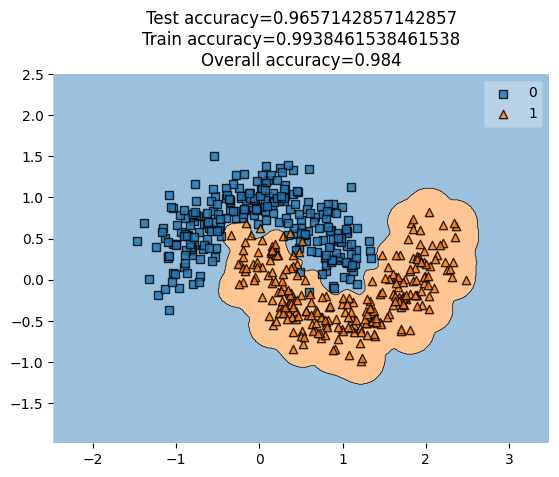

In [339]:
show_decisions_moons(mk_svm_rbf(100))

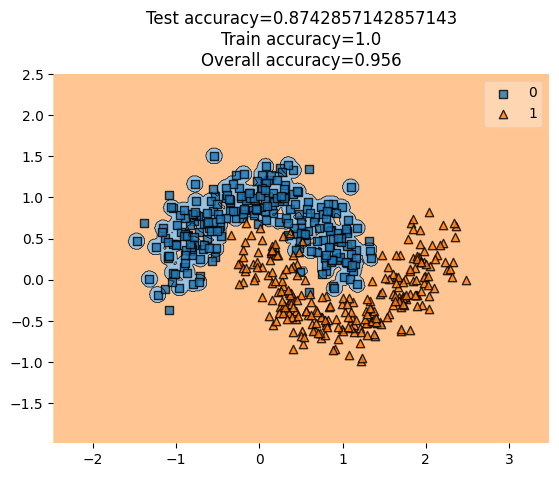

In [340]:
show_decisions_moons(mk_svm_rbf(500))

The last one is just indecently overfitted. Thus, of course, test accuracy is dropping 

### sigmoid

In [341]:
def mk_svm_sigmoid(γ='scale'):
    return SVC(kernel="rbf", gamma=γ)

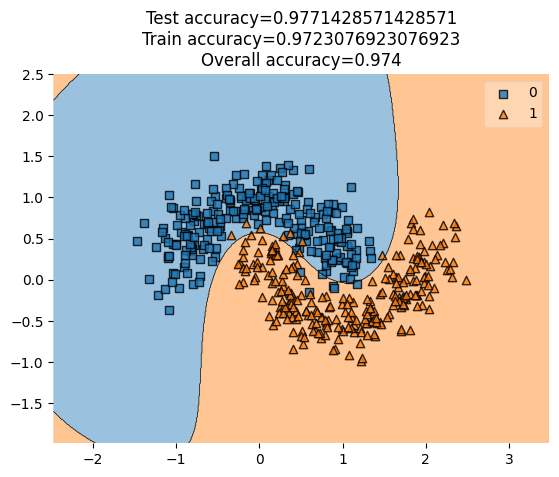

In [342]:
show_decisions_moons(mk_svm_sigmoid())

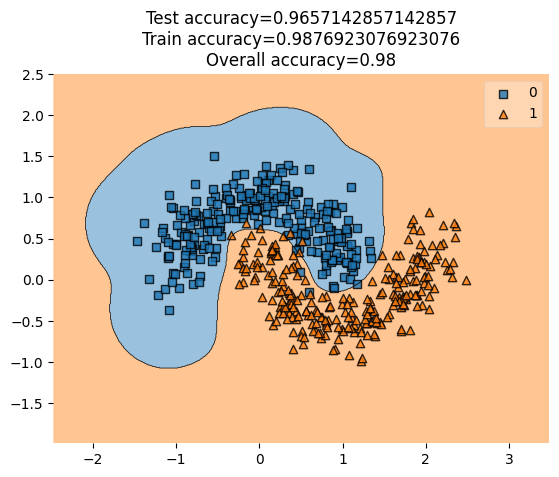

In [343]:
show_decisions_moons(mk_svm_sigmoid(10))

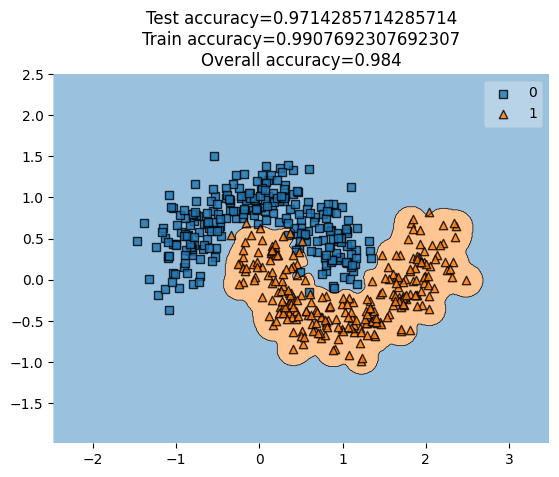

In [344]:
show_decisions_moons(mk_svm_sigmoid(100))

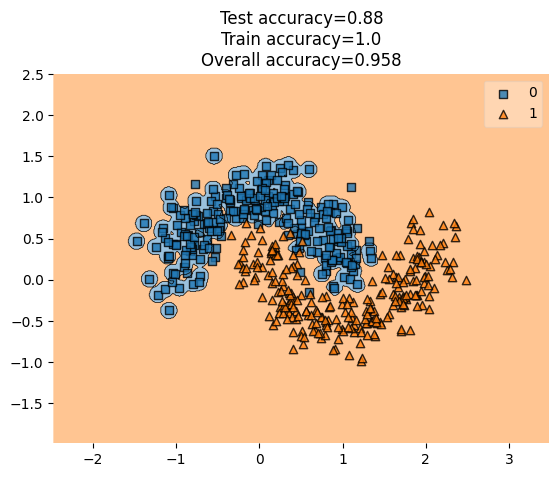

In [345]:
show_decisions_moons(mk_svm_sigmoid(500))

Same situation as with rbf.

## 1.3 Simpler solution (of a kind)
What is we could use Logisitc Regression to successfully solve this task?

Feature generation is a thing to help here. Different techniques of feature generation are used in real life, couple of them will be covered in additional lectures.

In particular case simple `PolynomialFeatures` ([link](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)) are able to save the day.

Generate the set of new features, train LR on it, plot decision regions, calculate metric.

* Comare SVM's results with this solution (quality, borders type)
* What degree of PolynomialFeatures have you used? Compare with same SVM kernel parameter.

In [394]:
from sklearn.preprocessing import PolynomialFeatures

def linear_svm_on_polynomial_data(degree):
    return Pipeline([
        ('Quadratise', PolynomialFeatures(degree=degree)),
        ('SVM', mk_svm_poly(1))
    ])

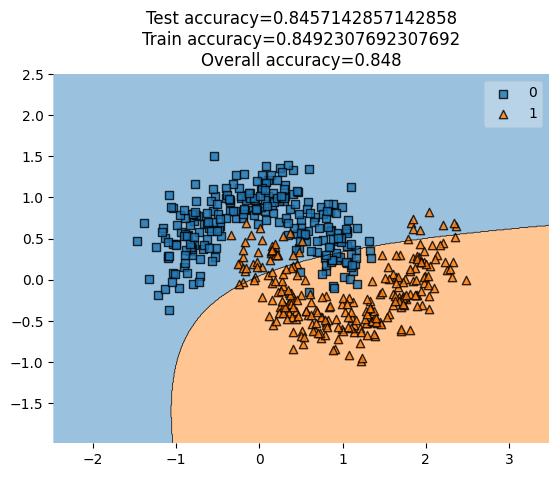

In [395]:
show_decisions_moons(linear_svm_on_polynomial_data(2))

Not much better than the baseline! Let's try increasing the degree

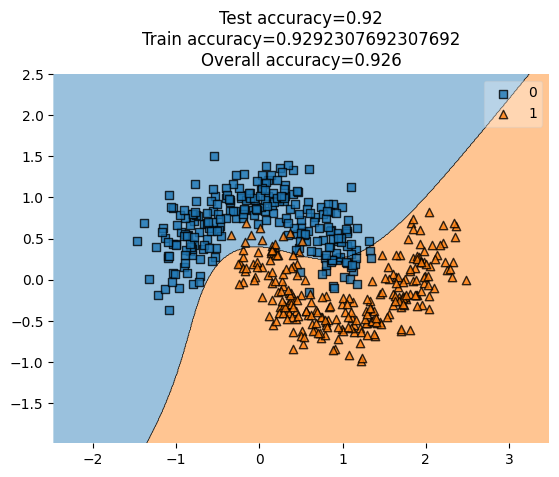

In [396]:
show_decisions_moons(linear_svm_on_polynomial_data(3))

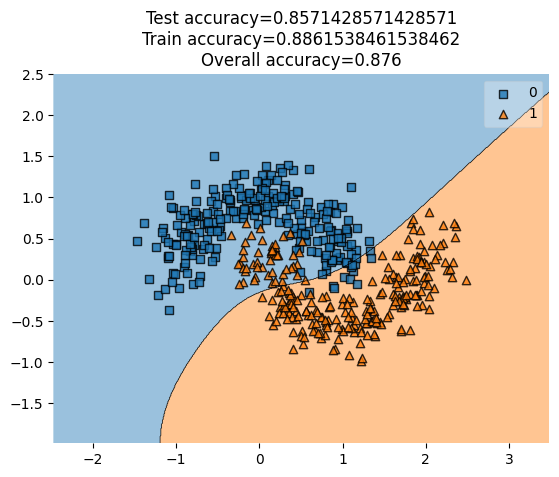

In [397]:
show_decisions_moons(linear_svm_on_polynomial_data(4))

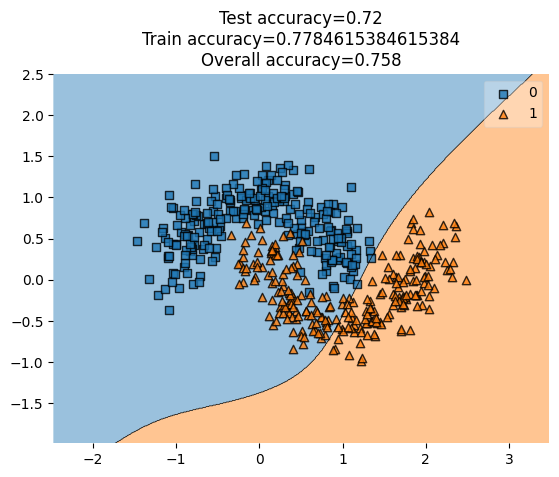

In [398]:
show_decisions_moons(linear_svm_on_polynomial_data(5))

Degree 3 is very good! It beats the baseline.

However, it's unintuitive that train accuracy decreases with the increase of degree, since polynomial features of $degree+1$ contain all the polynomial features of $degree$.

If two datasets are separated by a hyperplane **ideally**, then so are these datasets with new features added. However, if the separation was not ideal, non-important features (which are as good as random) might add some noise and make the already non-ideal separation even worse.

Thus, adding polynomial features is a nice, clever trick, but adding non-important features might reduce accuracy. So, it is better to add *motivated* features, as I will do further. Do not add all the stuff you can come up with 

## 1.4 Harder problem

Let's make this task a bit more challenging via upgrading dataset:

### Circles

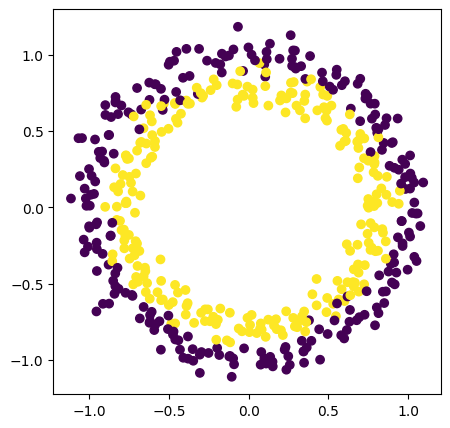

In [347]:
from sklearn.datasets import make_circles


circles_points, circles_labels = make_circles(n_samples=500, noise=0.06, random_state=42)

plt.figure(figsize=(5, 5))
draw_colorful_points(circles_points, circles_labels)

In [348]:
def show_decisions_circles(clf, a=0.35):
    show_decisions(clf, X=circles_points, y=circles_labels, a=a)

The two first ideas that come to mind are quadratic SVM and KNN. Let's try!

In [349]:
knn = KNeighborsClassifier()

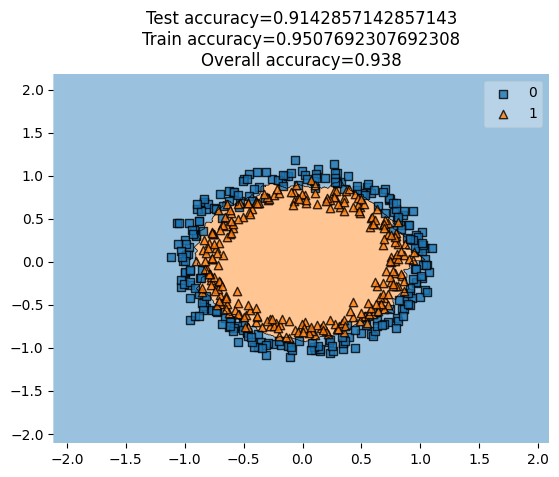

In [350]:
show_decisions_circles(knn)

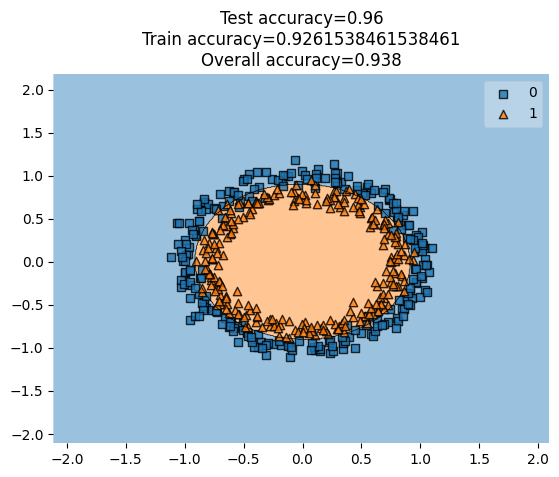

In [351]:
show_decisions_circles(mk_svm_poly(2))

The results are very similar (and both fit data very good)<s>, but SVM is, as expected, much-much faster.</s>

Quadratic SVM will be our baseline, one that is simple and hard to compete with

In fact, a linear SVM can work, too! All we need is polar coordinates

In [352]:
def xy2polar(x, y):
    r2 = (x * x + y * y)
    θ = np.arctan2(y, x)
    return r2, θ

def data2polar(X):
    r2, θ = xy2polar(X[:, 0], X[:, 1])
    return np.array([r2, θ]).T

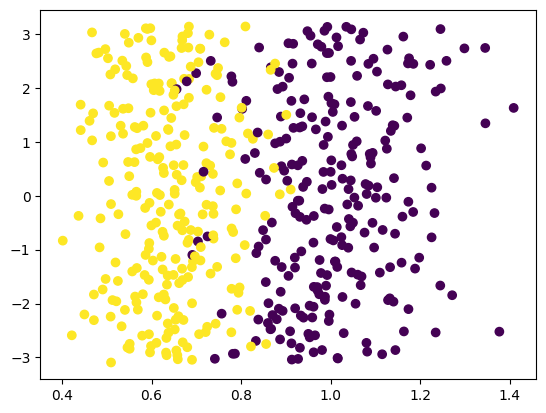

In [353]:
circles_points_polar = data2polar(circles_points)
draw_colorful_points(circles_points_polar, circles_labels)

In [354]:
def show_decisions_circles_polar(clf, a=0.35):
    show_decisions(clf, X=circles_points_polar, y=circles_labels, a=a)

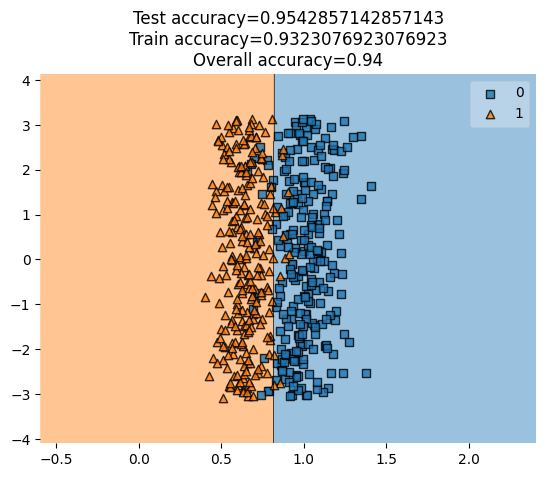

In [355]:
show_decisions_circles_polar(mk_svm_poly(1))

We can try changing the power of radius to make the separation more clear. I tried it on my own and found nothing worth noting. However, if I were optimizing metrics, not just the visual goodness of separation, the power of radius would've been a reasonable hyperparameter to wiggle.


In reality, I do not even need $\theta$'s:

In [356]:
def show_decisions_circles_radius(clf, a=0.35):
    n_samples, n_features = circles_points_polar.shape
    # random instead of zeros, to have a proper cloud, not a line
    X = np.array([circles_points_polar[:, 0], np.random.uniform(low=-1, high=1, size=n_samples)]).T
    show_decisions(clf, X=X, y=circles_labels, a=a)

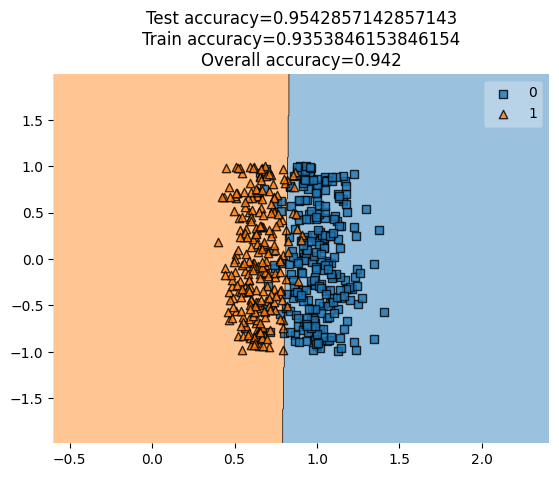

In [357]:
show_decisions_circles_radius(mk_svm_poly(1))

<s>Accuracy with random second feature exceeds accuracy for polar data :)))</s> Not on this run; but it's still *not worse* than before.

Linear SVM does not beat the baseline, but does not lose to it, too. Since linear SVM is more efficient and harder to overfit than quadratic SVM, I would choose this one

This is almost a special case of PolynomialFeatures (almost, since $\theta$ is not polynomial; still, as we have seen, it can be replaced.) Let's compare!

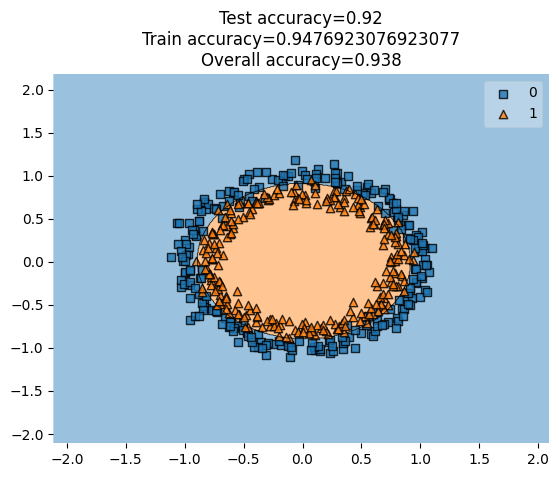

In [399]:
show_decisions_circles(linear_svm_on_polynomial_data(2))

Accuracy is less. Extra features get in the way again. 

Switching to polar coordinates is motivated feature-generation, and using polynomial features is desperate feature-generation. The former yields more accuracy. Thus, using your head is useful

### Yin and Yang ☯ ︎

And even more:

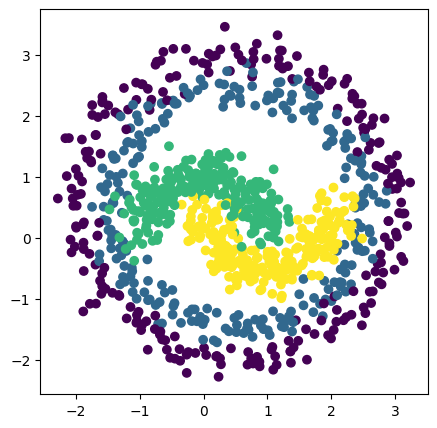

In [358]:
yypoints = np.vstack((circles_points * 2.5 + 0.5, moons_points))
yylabels = np.hstack((circles_labels, moons_labels + 2))  # + 2 to distinct moons classes

plt.figure(figsize=(5, 5))
draw_colorful_points(yypoints, yylabels)

In [359]:
def show_decisions_yy(clf, a=0.35):
    show_decisions(clf, X=yypoints, y=yylabels, a=a)

Now do your best using all the approaches above!

Tune LR with generated features, SVM with appropriate kernel of your choice. You may add some of your loved models to demonstrate their (and your) strength. Again plot decision regions, calculate metric.

Justify the results in a few phrases.

I do not know which baseline to choose... My baseline would be scaled rbf, and I do not hope beating it

c:\Users\Игорь\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


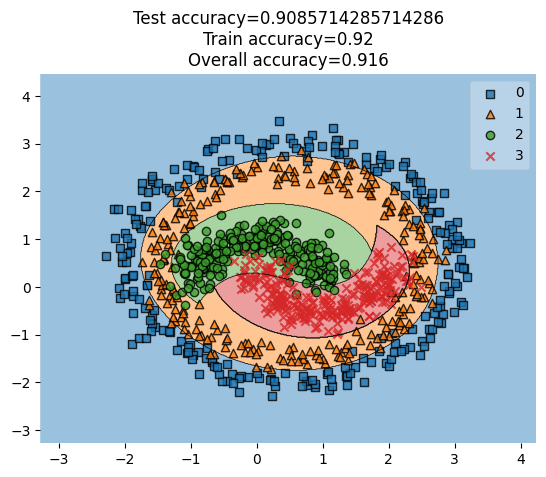

In [379]:
show_decisions_yy(mk_svm_rbf())

#### Linear SVM 

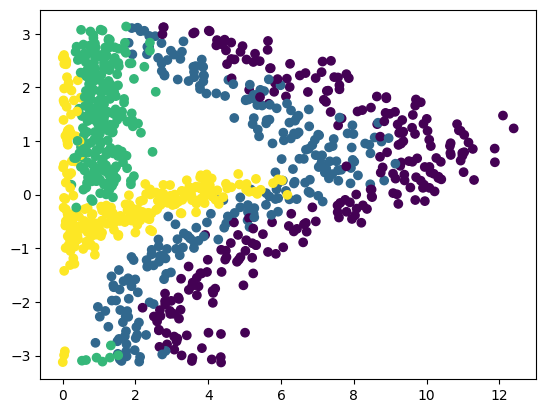

In [360]:
yypolarFAIL = data2polar(yypoints)
draw_colorful_points(yypolarFAIL, yylabels)


Oops! The data is not centred or normalized. Let's fix this

In [400]:
def train_val_test_split(data, target, a=0.35, b=0.1):
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=a)
    X_train, X_val, y_train, y_val = train_test_split(data, target, test_size=b)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [402]:
yytrain, yyval, yytest, yylabels_train, yylabels_val, yylabels_test = \
      train_val_test_split(yypoints, yylabels)
scaler = StandardScaler()
scaler.fit(yytrain)
yyscaled = scaler.transform(yypoints)

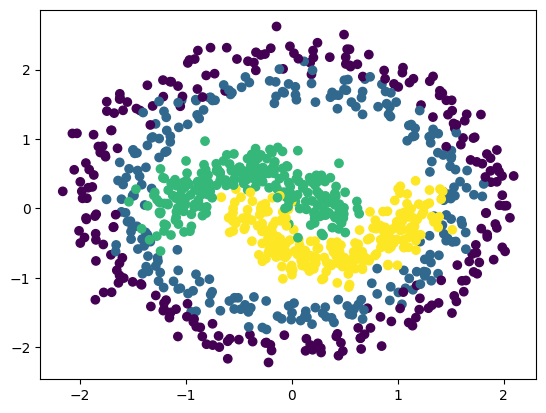

In [403]:
draw_colorful_points(yyscaled, yylabels)

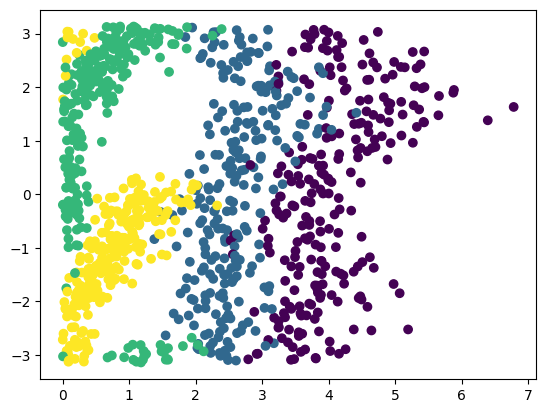

In [363]:
yypolar = data2polar(yyscaled)
draw_colorful_points(yypolar, yylabels)

Still not perfect, but much better.

In [364]:
def show_decisions_yy_polar(clf, a=0.35):
    show_decisions(clf, X=yypolar, y=yylabels, a=a)

c:\Users\Игорь\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


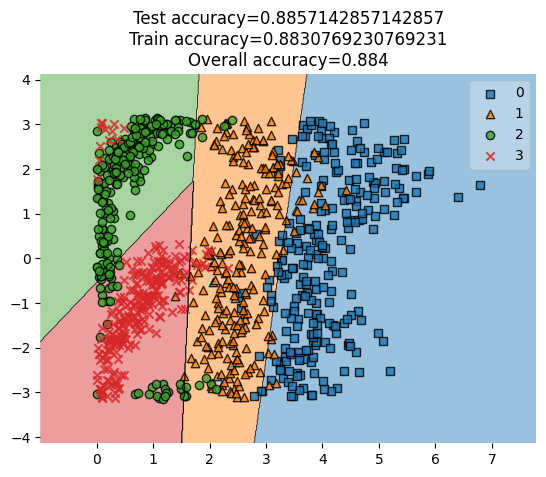

In [421]:
show_decisions_yy_polar(mk_svm_poly(1))

This isn't too bad, actually! Although $yypolar$ looks quite ugly, the separating lines are sort of there --- and SVM found them without trouble!

##### polar variations

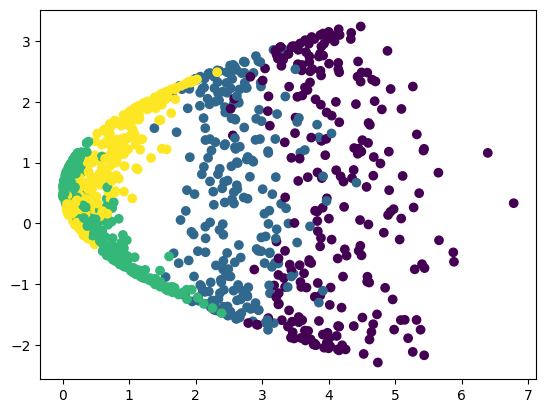

In [366]:
yy_r2x = np.array([yypolar[:, 0], yypoints[:, 0]]).T
draw_colorful_points(yy_r2x, yylabels)

c:\Users\Игорь\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


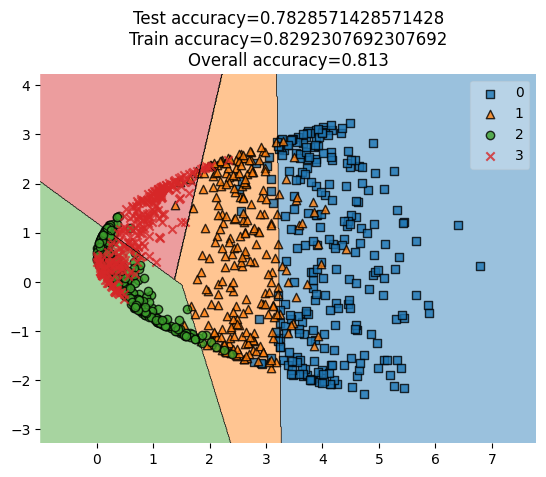

In [367]:
show_decisions(clf=mk_svm_poly(1), X=yy_r2x, y=yylabels)

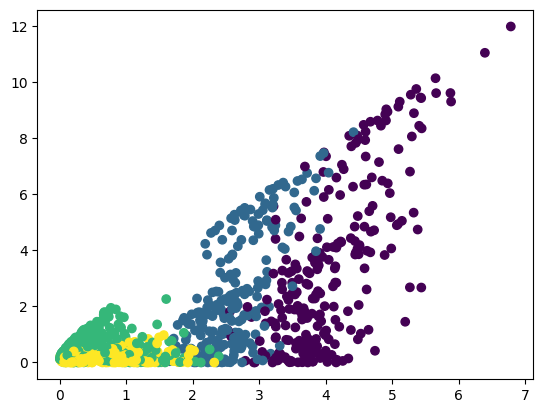

In [368]:
yy_r2y2 = np.array([yypolar[:, 0], yypoints[:, 1]**2]).T
draw_colorful_points(yy_r2y2, yylabels)

c:\Users\Игорь\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


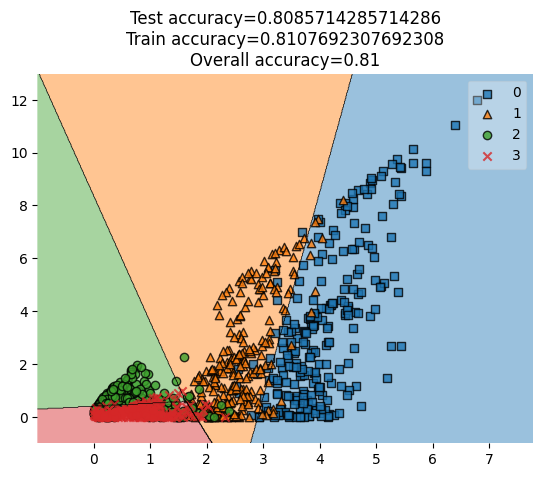

In [369]:
show_decisions(clf=mk_svm_poly(1), X=yy_r2y2, y=yylabels)

##### grid search

Since linear SVM in polar coordinates works fast (<s>a property we should not take for granted, as following examples show</s>) and nice, we can try grid searching a bit to improve further. 

In [416]:
def grid_search_weights(get_f1val, start=1, end=2, num=5):
    def name_weights(ws):
        return {i : ws[i] for i in range(4)}
    def get_f1val_unnamed(ws):
        return get_f1val(name_weights(ws))

    w_best_found = [1,1,1,1]
    f1w_best_found = get_f1val_unnamed(w_best_found)
    grid = np.linspace(start, end, num)
    for w1 in grid:
        for w2 in grid:
            for w3 in grid:
                for w4 in grid:
                    f1w = get_f1val_unnamed([w1, w2, w3, w4])
                    if f1w > f1w_best_found:
                        f1w_best_found = f1w
                        w_best_found = [w1, w2, w3, w4]
    return name_weights(w_best_found)

In [417]:
def get_f1val_yypolar_linear_svm(w):
    m = mk_svm_poly(degree=1, class_weight=w)
    m.fit(yytrain, yylabels_train)
    yylabels_pred_val = m.predict(yyval)
    return accuracy_score(y_true=yylabels_val, y_pred=yylabels_pred_val)

In [418]:
yyw_best_found_polar = grid_search_weights(get_f1val_yypolar_linear_svm)
yyw_best_found_polar

{0: 1.0, 1: 1.0, 2: 1.0, 3: 2.0}

c:\Users\Игорь\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


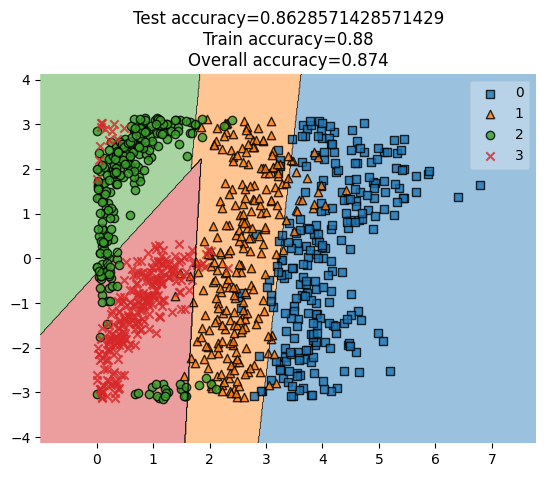

In [420]:
show_decisions_yy_polar(mk_svm_poly(1, class_weight=yyw_best_found_polar))

Grid search failed to improve accuracy.

#### Other SVMs

##### sigmoid

c:\Users\Игорь\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


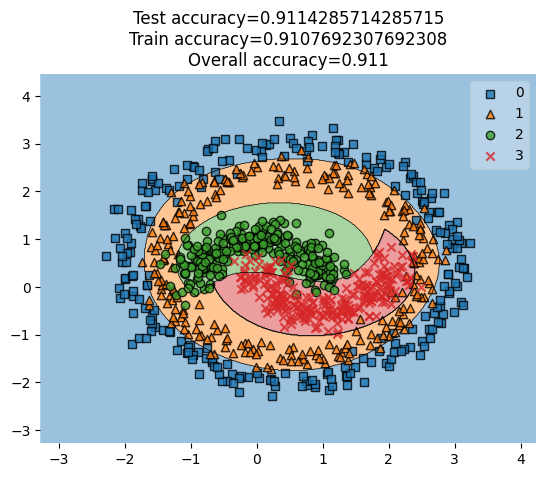

In [371]:
show_decisions_yy(mk_svm_sigmoid())

c:\Users\Игорь\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


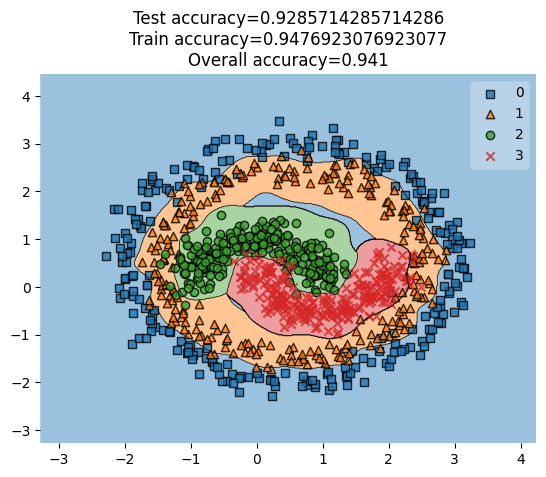

In [372]:
show_decisions_yy(mk_svm_sigmoid(10))

Comments for sigmoid are the same as for rbf, so see below.

##### rbf

c:\Users\Игорь\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


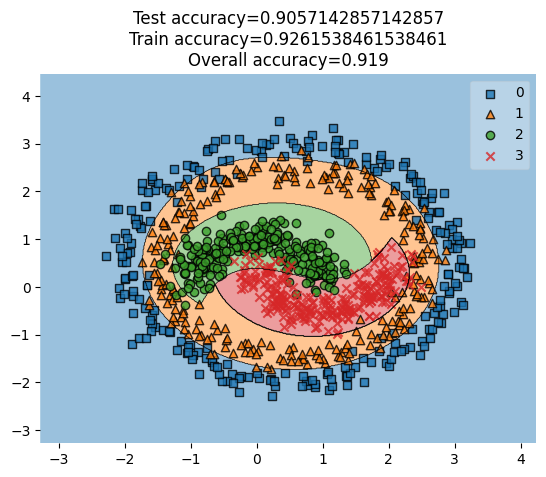

In [373]:
show_decisions_yy(mk_svm_rbf())

<s>This took quite a while, 4-5 times longer than the linear SVM</s>, and gave just a $2\%$ improvement.
Turns out, the time issue comes from the mlxtend's painter; so comparing times is not reasonable here

#### kNN

c:\Users\Игорь\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


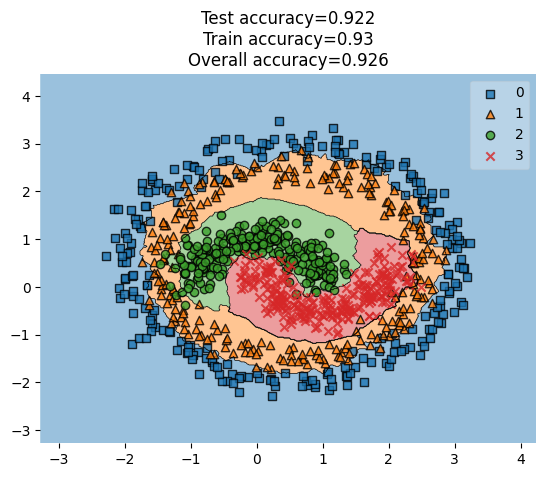

In [380]:
show_decisions_yy(knn, a=0.5)

As always, looks very nice, but works very slow (but faster than rbf and sigmoid!).

# Conclusion

Although linear SVM does not beat smarter kernels, it can compete with them, if we take time and risk to overfit into account. Of course, if we feature engineer successfully.